In [1]:
# !pip install opencv-python
# !pip install k4a
# !pip install open3d
# !pip install pyk4a
# !pip install --upgrade lxml

  Using cached lxml-4.9.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (7.1 MB)


In [1]:
import os
import time
import uuid
import cv2
import numpy as np
import pyk4a
from pyk4a import PyK4A, Config, depth_image_to_color_camera
from matplotlib import pyplot as plt
import lxml.etree 
from lxml.builder import E

### Test capture for single frame

In [2]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    img = img.copy()
    img_h, img_w, _ = img.shape
    h, w = 600, 600
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols
    
    # draw vertical lines
    x_start = int((img_w - w) / 2)
    x_end = int(w + x_start)
    y_start = int((img_h - h) / 2)
    y_end = int(h + y_start)
    
    for x in np.linspace(start = x_start + 10, stop= x_end - 10, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, y_start + 10), (x, y_end - 10), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start= y_start + 10, stop= y_end - 10, num=rows-1):
        y = int(round(y))
        cv2.line(img, (x_start + 10, y), (x_end - 10, y), color=color, thickness=thickness)

    cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color=(0, 0, 255), thickness=thickness)

    return img

In [3]:
def get_bounding_box(img, table): 
  y_min = 10000
  y_max = 0
  x_min = 10000
  x_max = 0
  for x in range(370, 930):
    for y in range(70, 650):
      k = img[y, x]
      if k < (table[y,x]-3) or k > (table[y,x]+3):
        if x > x_max:
          x_max = x #- 1
        if y > y_max:
          y_max = y #- 1
        if x < x_min:
          x_min = x #- 1
        if y < y_min:
          y_min = y #- 1
  return y_min, y_max, x_min, x_max

In [20]:
def get_bounding_box_rgb(img, table):
    y_min = 10000
    y_max = 0
    x_min = 10000
    x_max = 0
    for x in range(370, 930):
        for y in range(70, 650):
            k = img[y, x]
            t = table[y, x]
            if k[0] < (t[0]-30) or k[0] > (t[0]+30) or k[1] < (t[1]-30) or k[1] > (t[1]+30) or k[2] < (t[2]-30) or k[2] > (t[2]+30) or k[3] < (t[3]-30) or k[3] > (t[3]+30):
                if x > x_max:
                    x_max = x #- 1
                if y > y_max:
                    y_max = y #- 1
                if x < x_min:
                    x_min = x #- 1
                if y < y_min:
                    y_min = y #- 1
    return y_min, y_max, x_min, x_max 

In [5]:
def get_yolo(width, height, y_min, y_max, x_min, x_max, obj, file):
  x_center = ((x_min + x_max) / 2) / width
  y_center = ((y_min + y_max) / 2) / height
  width = (x_max - x_min) / width
  height = (y_max - y_min) / height

  file_name = str(file) + '.txt'
    
  f = open(os.path.join(YOLO_LABEL_PATH, file_name), 'x')
  f.write(f'{obj} {x_center} {y_center} {width} {height}' )


In [6]:
def get_pascal_voc(width, height, y_min, y_max, x_min, x_max, obj, file):
    file_name_picture = str(file) + ".png"
    file_name = str(file) + ".xml"
    
    E = lxml.builder.ElementMaker()
    ANNOTATION = E.annotation
    FOLDER = E.folder
    FILENAME = E.filename
    PATH = E.path
    SOURCE = E.source
    DATABASE = E.database
    SIZE = E.size
    WIDTH = E.width
    HEIGHT = E.height
    DEPTH = E.depth
    SEGMENTED = E.segmented
    OBJECT = E.object
    NAME = E.name
    POSE = E.pose
    TRUNCATED = E.truncated
    DIFFICULT = E.difficult
    BNDBOX = E.bndbox
    XMIN = E.xmin
    YMIN = E.ymin
    XMAX = E.xmax
    YMAX = E.ymax
    
    doc = ANNOTATION(
            FOLDER("pascal_voc"),
            FILENAME(file_name_picture),
            PATH(os.path.join(RGB_IMAGE_PATH, file_name_picture)),
            SOURCE(
                DATABASE("Unknown")
            ),
            SIZE(
                WIDTH(str(width)),
                HEIGHT(str(height)),
                DEPTH("3"),
            ),
            SEGMENTED("0"),
            OBJECT(
                NAME(obj),
                POSE("Unspecified"),
                TRUNCATED("0"),
                DIFFICULT("0"),
                BNDBOX(
                    XMIN(str(x_min)),
                    YMIN(str(y_min)),
                    XMAX(str(x_max)),
                    YMAX(str(y_max)),
                )
            )
        ) 
    f = open(os.path.join(PASCAL_LABEL_PATH, file_name), 'x')
    f.write(lxml.etree.tostring(doc, pretty_print=True).decode("utf-8"))

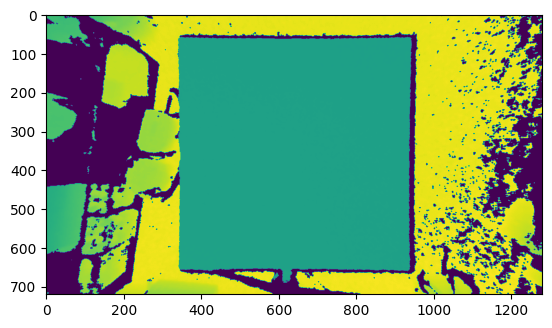

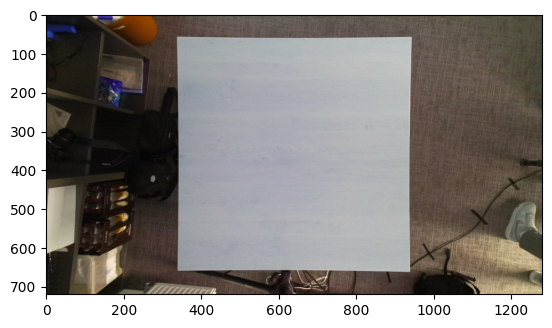

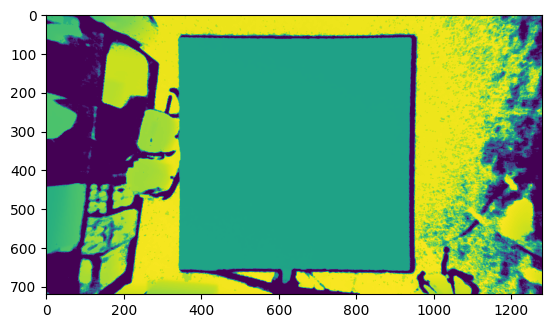

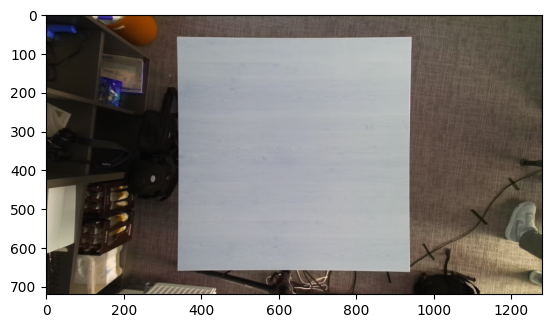

In [7]:
# Load camera with the default config
k4a = PyK4A(
    Config(
        camera_fps= pyk4a.FPS.FPS_5,
        depth_mode=pyk4a.DepthMode.WFOV_UNBINNED
    )
)
k4a.start()
while True:
    capture = k4a.get_capture()
    
    img_color = capture.color
    img_depth = capture.depth   

    # Convert Depth Image to same aspect ratio as RGB image
    img_depth = depth_image_to_color_camera(img_depth, k4a.calibration, True)
    
    # Display windows  
    cv2.imshow("RGB Image", draw_grid(img_color, (7,7), (255, 0, 0)))

    key = cv2.waitKey(1)
    if key == ord("q"):
        cv2.destroyAllWindows()
        break

# Get the next capture (blocking function)
capture = k4a.get_capture()

# Convert BGR to RGB
prev_color = capture.color
prev_color = img_color[:, :, 2::-1]
prev_depth = capture.depth
prev_depth = depth_image_to_color_camera(prev_depth, k4a.calibration, True)
depth_groundtruth = capture.depth
depth_groundtruth = depth_image_to_color_camera(depth_groundtruth, k4a.calibration, True)
rgb_groundtruth = capture.color/10

# Display with pyplot
plt.imshow(img_depth) 
plt.show()
plt.imshow(img_color) 
plt.show()

for i in range(9):
    time.sleep(0.2)
    capture = k4a.get_capture()
    depth_sample = capture.depth
    depth_sample = depth_image_to_color_camera(depth_sample, k4a.calibration, True)
    depth_groundtruth += depth_sample
    rgb_sample = capture.color/10
    rgb_groundtruth += rgb_sample

depth_groundtruth = depth_groundtruth/10
plt.imshow(depth_groundtruth)
plt.show()
rgb_groundtruth = np.around(rgb_groundtruth, 0).astype(int)
plt.imshow(rgb_groundtruth)
plt.show()

k4a.stop()

### Capture live feed and save RGB-D images

In [8]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")
OBJECT_CLASS = "test_annotation_rgb"

OBJECT_PATH = os.path.join(IMAGE_PATH, OBJECT_CLASS)

RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")
ANNOTATED_IMAGE_PATH = os.path.join(OBJECT_PATH, "annotation")
YOLO_LABEL_PATH = os.path.join(OBJECT_PATH, "yolo")
PASCAL_LABEL_PATH = os.path.join(OBJECT_PATH, "pascal_voc")

In [9]:
# Create images folder
if not os.path.exists(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)

# Create folder for object
if not os.path.exists(OBJECT_PATH):
    os.mkdir(OBJECT_PATH)
    
# Create folder rgb
if not os.path.exists(RGB_IMAGE_PATH):
    os.mkdir(RGB_IMAGE_PATH)
    
# Create folder depth
if not os.path.exists(DEPTH_IMAGE_PATH):
    os.mkdir(DEPTH_IMAGE_PATH)
    
# Create folder annotation
if not os.path.exists(ANNOTATED_IMAGE_PATH):
    os.mkdir(ANNOTATED_IMAGE_PATH)
    
# Create folder yolo label
if not os.path.exists(YOLO_LABEL_PATH):
    os.mkdir(YOLO_LABEL_PATH)
    
# Create folder yolo label
if not os.path.exists(PASCAL_LABEL_PATH):
    os.mkdir(PASCAL_LABEL_PATH)

In [22]:
# Load camera with the default config
k4a = PyK4A(
    Config(
        camera_fps= pyk4a.FPS.FPS_5,
        depth_mode=pyk4a.DepthMode.WFOV_UNBINNED
    )
)
k4a.start()

# Get the next capture (blocking function)
capture = k4a.get_capture()

while True:
    capture = k4a.get_capture()
    
    img_color = capture.color
    img_depth = capture.depth 
    
    # Convert Depth Image to same aspect ratio as RGB image
    img_depth = depth_image_to_color_camera(img_depth, k4a.calibration, True)
    
    #y_min, y_max, x_min, x_max = get_bounding_box(img_depth, depth_groundtruth)
    #start_point = (x_min, y_min) 
    #end_point = (x_max, y_max)
    #color = (0, 255, 0)  
    #thickness = 1
    
    #img_color = cv2.rectangle(img_color, start_point, end_point, color, thickness)
    
    
    # Display windows  
    cv2.imshow("RGB Image", draw_grid(img_color, (7,7), (255, 0, 0)))
    #cv2.imshow("Depth Image", img_depth)
    
    key = cv2.waitKey(1)
    
    if key == ord('m'):
        id = f'{str(uuid.uuid1())}'
        file_name = f'{id}.png'

        cv2.imwrite(os.path.join(RGB_IMAGE_PATH, file_name), img_color)
        cv2.imwrite(os.path.join(DEPTH_IMAGE_PATH, file_name), img_depth)
        depth_annotation = img_depth
        rgb_annotation = img_color/10
        for i in range(9):
            time.sleep(0.2)
            capture = k4a.get_capture()
            depth_sample = capture.depth
            depth_sample = depth_image_to_color_camera(depth_sample, k4a.calibration, True)
            depth_annotation += depth_sample
            rgb_sample = capture.color/10
            rgb_annotation += rgb_sample
        depth_annotation = depth_annotation/10
        rgb_annotation = np.around(rgb_annotation, 0).astype(int)
        #y_min, y_max, x_min, x_max = get_bounding_box(depth_annotation, depth_groundtruth)
        y_min, y_max, x_min, x_max = get_bounding_box_rgb(rgb_annotation, rgb_groundtruth)

        start_point = (x_min, y_min) 
        end_point = (x_max, y_max)
        color = (255, 0, 0)  
        thickness = 1

        width = int(img_color.shape[1])
        height = int(img_color.shape[0])
        rgb_rect = cv2.rectangle(img_color, start_point, end_point, color, thickness)
        cv2.imwrite(os.path.join(ANNOTATED_IMAGE_PATH, file_name), rgb_rect)

        get_yolo(width, height, y_min, y_max, x_min, x_max, 0, id)
        get_pascal_voc(width, height, y_min, y_max, x_min, x_max, "cup", id)

    if key == ord("q"):
        cv2.destroyAllWindows()
        break
        
k4a.stop()